# Exploratory Data Analysis for Hypertension Prediction

In this notebook, we will perform exploratory data analysis (EDA) on the humidity dataset to understand trends and patterns that may influence hypertension prevalence.

In [65]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import r2_score

# Set visualization style
sns.set(style='whitegrid')

In [66]:
# Load the training dataset
train_data = pd.read_csv('data/train.csv')

# Display the first few rows of the dataset
train_data.head()

,date,Lembab
0,2007-01-31,77.9
1,2007-02-28,81.8
2,2007-03-31,84.1
3,2007-04-30,82.6
4,2007-05-31,75.3


In [67]:
# Check for missing values
train_data.isnull().sum()

date      0
Lembab    0
dtype: int64

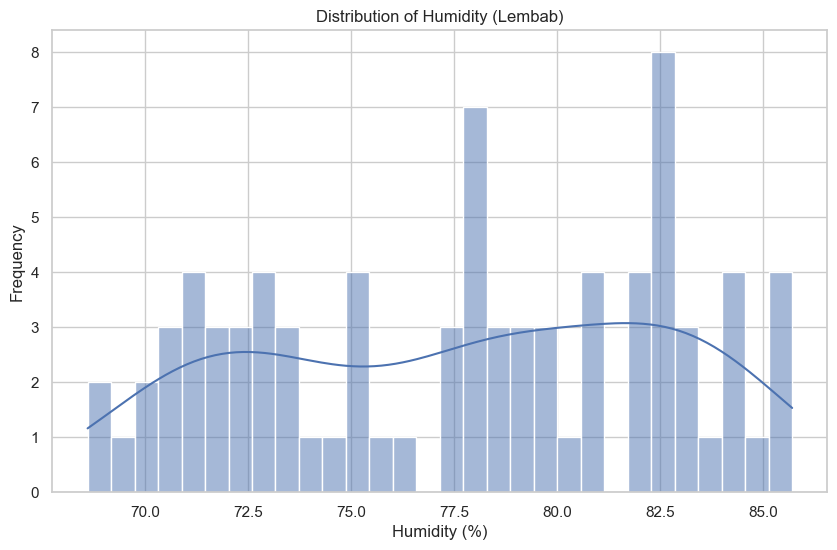

In [68]:
# Visualize the distribution of humidity values
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Lembab'], bins=30, kde=True)
plt.title('Distribution of Humidity (Lembab)')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()

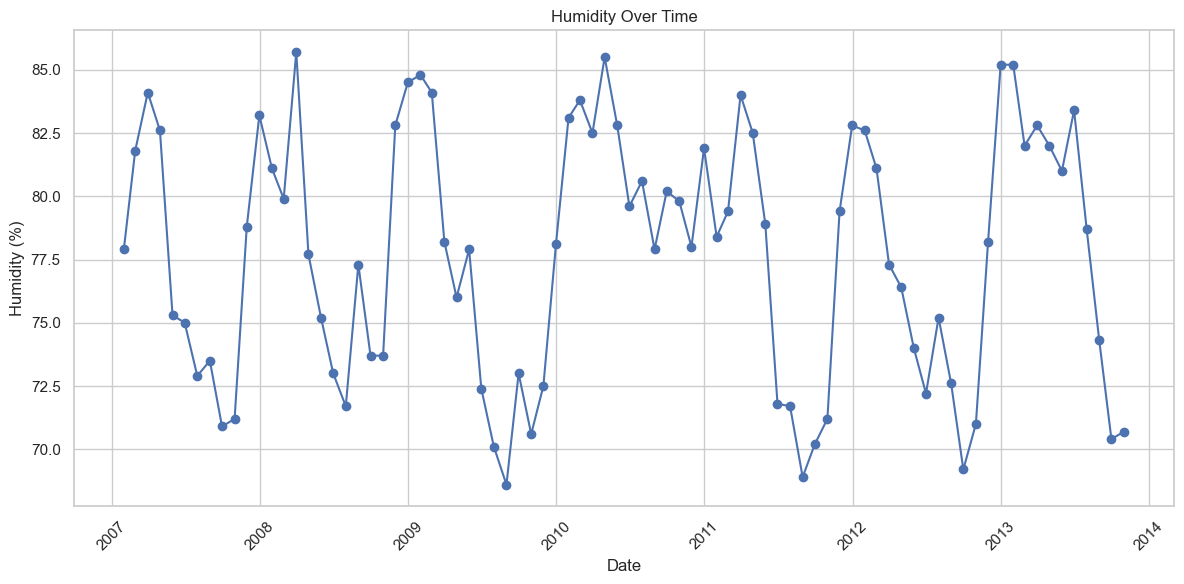

In [69]:
# Time series analysis of humidity over time
train_data['date'] = pd.to_datetime(train_data['date'])
plt.figure(figsize=(12, 6))
plt.plot(train_data['date'], train_data['Lembab'], marker='o')
plt.title('Humidity Over Time')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Data Preprocessing

In [70]:
# Gunakan fungsi prepare_data yang sudah dibuat
def prepare_data(df):
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Extract time-based features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek
    
    # Add seasonal features & lag features
    df['season'] = df['month'].apply(lambda x: 0 if x in [12,1,2] 
                                else 1 if x in [3,4,5]
                                else 2 if x in [6,7,8] 
                                else 3)

    #Create lag features
    for i in range(1, 4):
        df[f'humidity_lag_{i}'] = df['Lembab'].shift(i)

    # Add rolling statistics
    df['humidity_rolling_mean'] = df['Lembab'].rolling(window=3).mean()
    df['humidity_rolling_std'] = df['Lembab'].rolling(window=3).std()

    # Drop rows with NaN from lag feature creation
    df = df.dropna()
    
    return df

# Preprocess data
train_processed = prepare_data(train_data)
test_processed = prepare_data(test_data)

## Split Data dan Training Model

In [71]:
# Prepare features
X_train = train_processed.drop(['date', 'Lembab'], axis=1)
y_train = train_processed['Lembab']

# Train models
models = {
    'rf': RandomForestRegressor(n_estimators=100, max_depth=10),
    'gb': GradientBoostingRegressor(n_estimators=100),
    'xgb': xgb.XGBRegressor(n_estimators=100)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = model

## Evaluasi Model

In [72]:
# Function untuk evaluasi
def evaluate_model(model, X, y, model_name):
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    print(f'{model_name} R² Score: {r2:.4f}')
    return predictions

# Evaluate each model
for name, model in results.items():
    predictions = evaluate_model(model, X_train, y_train, name)

rf R² Score: 0.9695
gb R² Score: 0.9989
xgb R² Score: 1.0000


## Visualisasi Hasil

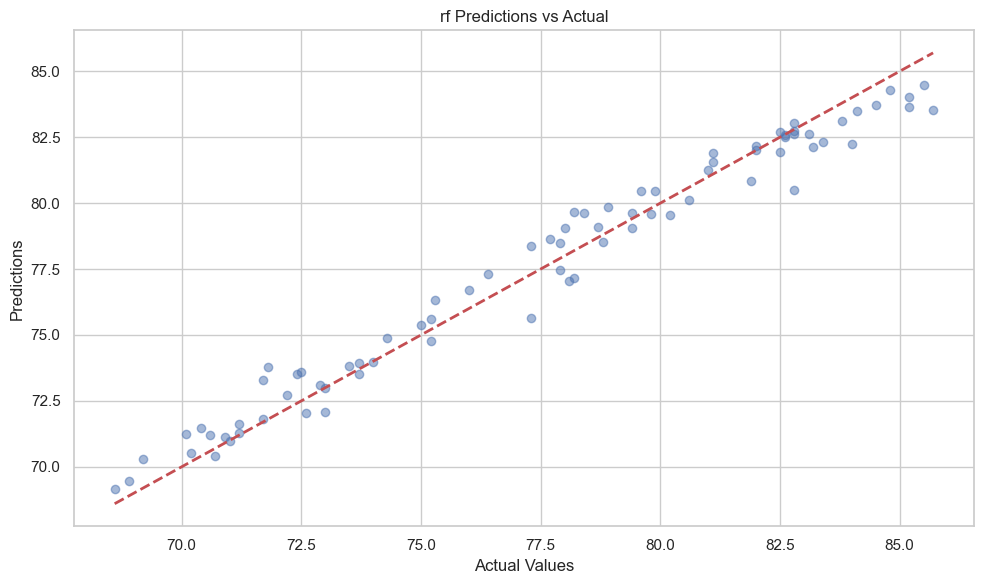

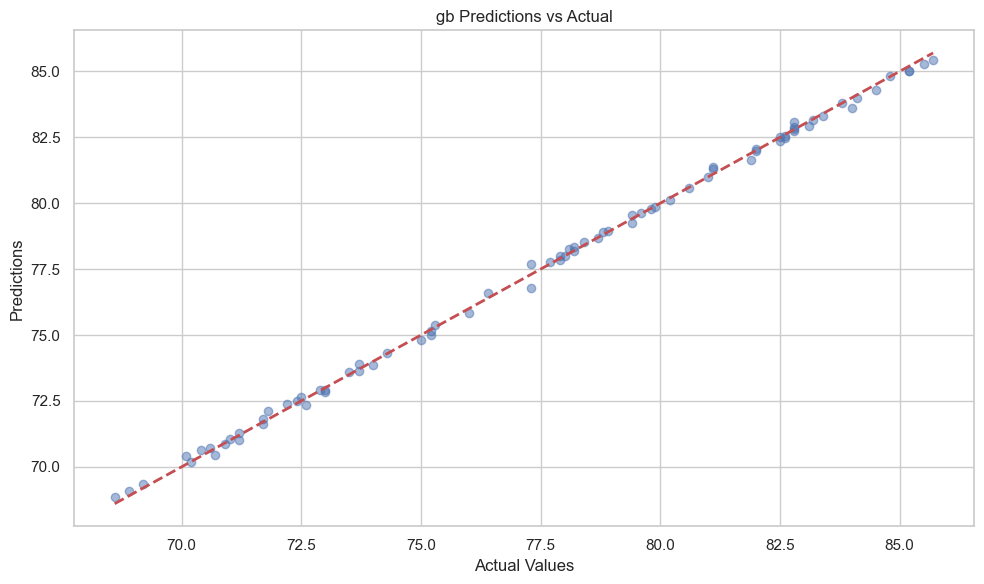

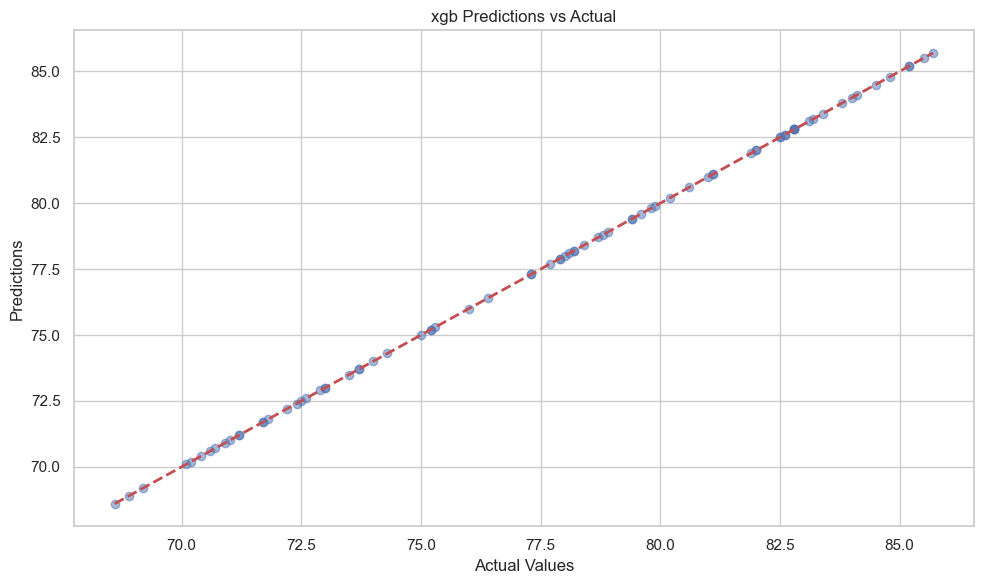

In [73]:
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot untuk setiap model
for name, model in results.items():
    predictions = model.predict(X_train)
    plot_predictions(y_train, predictions, f'{name} Predictions vs Actual')

## Feature Importance Analysis

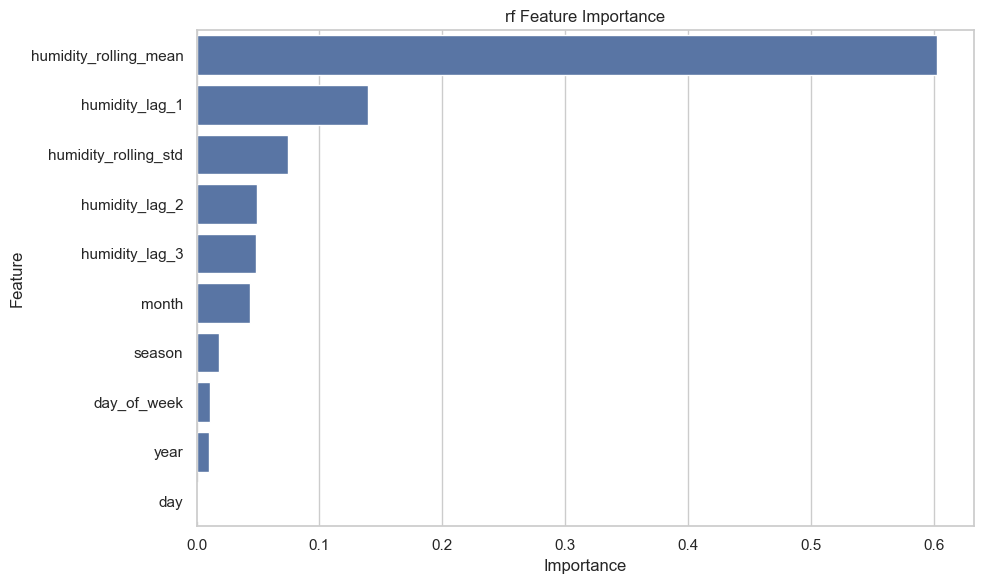

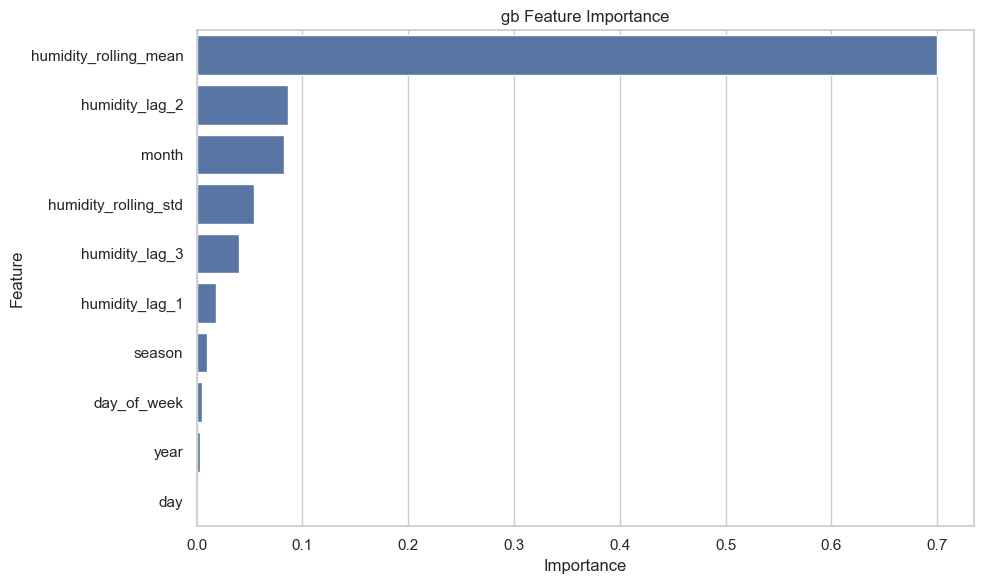

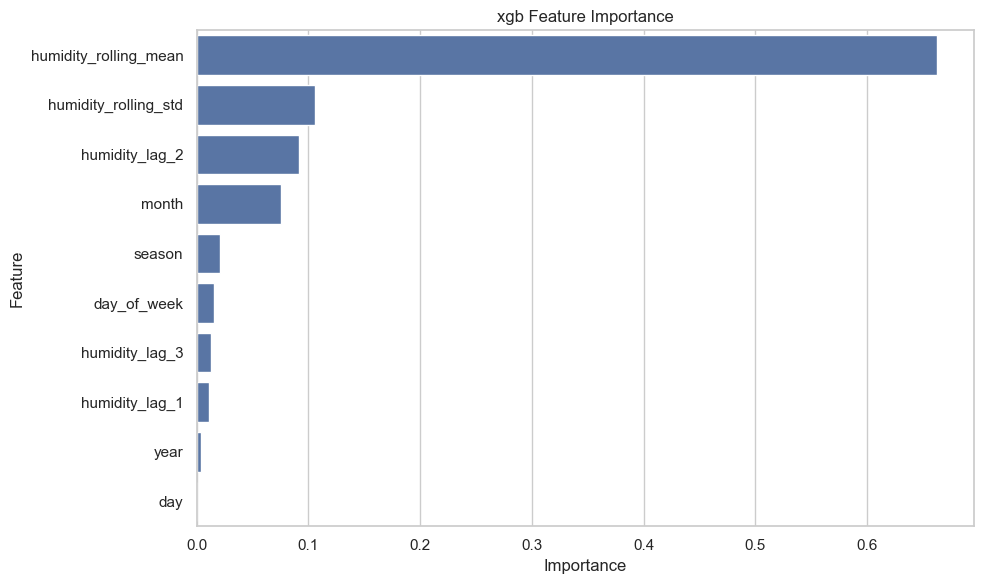

In [74]:
def plot_feature_importance(model, features, model_name):
    importance = model.feature_importances_
    feat_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feat_importance, x='Importance', y='Feature')
    plt.title(f'{model_name} Feature Importance')
    plt.tight_layout()
    plt.show()

# Plot feature importance untuk setiap model
for name, model in results.items():
    plot_feature_importance(model, X_train.columns, name)

## Generate Predictions untuk Test Set

In [75]:
# 1. Check if test_processed has data
if len(test_processed) == 0:
    raise ValueError("test_processed is empty")

print(f"test_processed shape: {test_processed.shape}")

# 2. Extract features used in training
train_features = train_processed.drop(['date', 'Lembab'], axis=1).columns
print(f"Training features: {train_features}")

# 3. Verify test data has same features
X_test = test_processed.drop(['date'], axis=1)  # Only drop date since test shouldn't have Lembab
missing_features = set(train_features) - set(X_test.columns)
if missing_features:
    raise ValueError(f"Test data missing features: {missing_features}")

# 4. Make predictions and validate
best_model = results['gb']
final_predictions = best_model.predict(X_test)

if len(final_predictions) != len(test_data):
    raise ValueError(f"Predictions length ({len(final_predictions)}) != test data length ({len(test_data)})")

# 5. Create submission with validation
submission = pd.DataFrame({
    'date': test_data['date'],
    'Lembab': final_predictions
})

# Verify date alignment
if not (submission['date'] == test_data['date']).all():
    raise ValueError("Date misalignment detected")

# Save with timestamp
timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
submission.to_csv(f'submission_{timestamp}.csv', index=False)

ValueError: test_processed is empty

In [63]:
# Predict menggunakan model terbaik
best_model = results['gb']  # atau model dengan R² terbaik
X_test = test_processed.drop(['date', 'Lembab'], axis=1)
final_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'date': test_data['date'],
    'Lembab': final_predictions
})
submission.to_csv('submission.csv', index=False)

ValueError: Found array with 0 sample(s) (shape=(0, 10)) while a minimum of 1 is required by GradientBoostingRegressor.